In [1]:
import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time

def get_rval(x):
    tmp = randint(0,99)
    if tmp%2:
        return randint(0,x-1)
    else:
        return randint(x+1,9)

def get_rval2(x):
    x1 = get_rval(x)
    x2 = get_rval(x)
    while abs(x1-x2)==1:
        x1 = get_rval(x)
        x2 = get_rval(x)
    return x1, x2

def get_random_occ_grid():
    row1 = randint(1,8)
    row2 = randint(1,8)
    while(row2 == row1 and row2 == row1 - 1 and row2 == row1 + 1):
        row2 = randint(1,8)
    col = randint(2,7)

    rc1, rc2 = get_rval2(col)
    cr1_1, cr1_2 = get_rval2(row1)
    cr2_1, cr2_2 = get_rval2(row2)

    occ_grid = np.ones((10,10))
    
    for i in range(10):
        if not (i==cr1_1 or i==cr1_2):
            occ_grid[row1,i] = 0

        if not (i==rc1 or i==rc2):
            occ_grid[i,col] = 0
            
        if not (i==cr2_1 or i==cr2_2):
            occ_grid[row2,i] = 0
            
            
    return occ_grid, row1, col



# Generating "DOF" definition of Landmark

In [2]:
total_data = 50
for num_data in range(total_data):
    occ_g, row1, col = get_random_occ_grid()
    data = occ_g.reshape(100)
    #fig1 = plt.figure(figsize=(10,6), dpi=80)
    #ax1 = fig1.add_subplot(111, aspect = 'equal')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    num_landmark = 1000
    num_neighbor = 200
    radius_landmark = 0.7
    #landmark = np.zeros((num_landmark, 2))
    #graph = nx.Graph()
    cnt = 0
    for i in range(num_landmark):
        x = np.random.uniform(0, 10)
        y = np.random.uniform(0, 10)
        if occ_g[int(x)][int(y)] == 0:
            continue

        ratio = 0.0
        minus = 0.0
        for j in range(num_neighbor):
            r = np.random.uniform(0, radius_landmark)
            theta = np.random.uniform(0, 2*np.pi)
            x_ = x + r * np.cos(theta)
            y_ = y + r * np.sin(theta)
            if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
                minus += 1
                continue
            if occ_g[int(x_)][int(y_)] == 1:
                ratio += 1
        ratio = ratio / (num_neighbor - minus)
        #graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
        if ratio <= 0.9:
            #print(ratio)
            data = np.append(data,x)
            data = np.append(data,y)
            #plt.scatter(x/10, y/10, color = 'blue', s = 10)
    '''
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
    plt.show()
    '''
    print(num_data, data.shape)
    np.save('/home/zhizuo/lego/dataset/landmark_{}'.format(str(num_data)),data)

0 (410,)
1 (470,)
2 (352,)
3 (500,)
4 (424,)
5 (464,)
6 (510,)
7 (522,)
8 (484,)
9 (518,)
10 (516,)
11 (484,)
12 (478,)
13 (458,)
14 (370,)
15 (490,)
16 (490,)
17 (474,)
18 (490,)
19 (442,)
20 (346,)
21 (384,)
22 (388,)
23 (462,)
24 (502,)
25 (390,)
26 (498,)
27 (466,)
28 (318,)
29 (376,)
30 (474,)
31 (476,)
32 (468,)
33 (362,)
34 (472,)
35 (492,)
36 (352,)
37 (394,)
38 (510,)
39 (368,)
40 (382,)
41 (498,)
42 (434,)
43 (332,)
44 (382,)
45 (480,)
46 (482,)
47 (458,)
48 (486,)
49 (414,)


In [2]:
import torch.nn as nn
import torch.nn.functional as F


# =======================
# CVAE (MLP version)
# =======================
class CVAE_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
        self.fc1 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x, c):
        inputs = torch.cat((x, c), 1)
        outputs = self.encoder(inputs)
        z_mu = self.fc1(outputs)
        z_logvar = self.fc2(outputs)
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        
        inputs_1 = torch.cat((z,c), 1)
        
        outputs_1 = self.decoder(inputs_1)
        return z_mu, z_logvar, outputs_1

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# =======================
# CVAE (CNN version)
# =======================
class CVAE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        def c_block(in_filters, out_filters, kernel_size = 3, stride = 1, padding = 1, bn=False):
            if bn:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.BatchNorm2d(out_filters),
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            else:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            return block
        
        #self.deconv_en = nn.ConvTranspose2d(2,1,10, stride = 1, padding=0)
        #self.decon_de = nn.ConvTranspose2d(2,1,10, stride = 1, padding = 0)
        
        # ====================
        # Encoder part
        # ====================
        self.deconv_en = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.encoder = nn.Sequential(
            *c_block(7,   32, 3, 2, 1),
            *c_block(32,  64, 3, 1, 0),
            *c_block(64,  128, 3, 1, 0),
        )
        
        self.mu_mlp = nn.Linear(128, 2)
        self.logvar_mlp = nn.Linear(128, 2)
        
        # ====================
        # Decoder part
        # ====================
        self.deconv_de = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.decoder = nn.Sequential(
            *c_block(7,   32, 3, 2, 1),
            *c_block(32,  64, 3, 1, 0),
            *c_block(64,  128, 3, 1, 0),
        )
        
        self.predict_mlp = nn.Linear(128, 2)
        
        
    def forward(self, x, c):
        # Encoder
        x = x.view(x.shape[0], 2, 1, -1)
        cat = c[:, 0:4]
        cat = cat.view(cat.shape[0], 4, 1, -1)
        x_en = torch.cat((x, cat), 1)
        c_en = c[:, 4:].view(c.shape[0], 1, 10, -1)
        deconv_x = self.deconv_en(x_en)
        input_en = torch.cat((deconv_x, c_en), 1)
        output_en = self.encoder(input_en)
        output_en = output_en.view(output_en.shape[0], 1, -1)
        z_mu = self.mu_mlp(output_en)
        z_logvar = self.logvar_mlp(output_en)

        
        # Latent space
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        z = z.view(z.shape[0], 2, 1, -1)
        # Decoder 
        z = torch.cat((z, cat), 1)
        z_deconv = self.deconv_de(z)
        input_decoder = torch.cat((z_deconv,c_en), 1)
        output_decoder = self.decoder(input_decoder)
        output_decoder = output_decoder.view(output_decoder.shape[0], 1, -1)
        predict = self.predict_mlp(output_decoder)
        predict = predict.view(predict.shape[0],-1)
        return z_mu, z_logvar, predict

    
def KL_loss(z_mu, z_logvar):
    return 2 * torch.sum(torch.exp(z_logvar) + 
                        z_mu**2 - 1. - z_logvar, dim=1).mean()
def Recon_loss(labels, predictions):
    loss = nn.MSELoss()
    return loss(labels, predictions)



In [10]:
import argparse
from torch import optim
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()
parser.add_argument("--max_epochs", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--eps", type=float, default=1e-8, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
#parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
#parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
#parser.add_argument("--channels", type=int, default=1, help="number of image channels")
#parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

landmark_data = []
total_data = 50
for i in range(total_data):
    data = np.load('/home/zhizuo/lego/dataset/landmark_{}.npy'.format(str(i)))
    length = data.shape[0]
    for j in range(int((length - 100)/2)) :
        tmp = np.concatenate((data[0:100], data[(100+j*2):(100+j*2+2)]))
        landmark_data.append(tmp)
        
landmark_data = np.array(landmark_data)
print(landmark_data.shape)
    
class LandmarkSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)
    



Namespace(b1=0.9, b2=0.999, batch_size=128, eps=1e-08, lr=0.0001, max_epochs=2000, n_cpu=8)
(8596, 102)


# Train for Lego Dataset

In [12]:
from torch.utils.data import Dataset, DataLoader
import networkx as nx
from process_it import process_it

# ==============================
# Lego shortest path dataset
# ==============================

class LegoSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)

    
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"

directory = data_dir
print(directory)
data = np.array(process_it(G, directory))
print("shape of array: ", data.shape)
numEntries = data.shape[0]
dim = 2
dataElements = dim * 3 + 10 * 10
z_dim = 2
X_dim = dim
y_dim = dim
ratioTestTrain = 0.8
numTrain = int(numEntries * ratioTestTrain)
X_train = data[0:numTrain, 0:dim]
c_train = data[0:numTrain, dim:dataElements]

X_test = data[numTrain:numEntries, 0:dim]
c_test = data[numTrain:numEntries, dim:dataElements]

path = "/Users/zhangzhizuo/Desktop/UCSD/Su Lab/Code Lego/"
train_data = LegoSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
test_data = LegoSet(x = X_test, c = c_test, train = False)
test_loader = DataLoader(test_data, batch_size = opt.batch_size, shuffle = False)

net = CVAE_CNN()
resume = None
#resume = "./Model/CVAE_CNN_2020_3_19_21.pkl"
if resume == None:
    net = CVAE_CNN()
else:
    net.load_state_dict(torch.load(resume))
    
if torch.cuda.is_available():
    net.cuda()
net.train()
optimizer = optimizer = optim.Adam(net.parameters(), lr=opt.lr, 
                      betas=(opt.b1, opt.b2), eps=1e-08, weight_decay=0)

for epoch in range(opt.max_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        batch_elements = [randint(0, numTrain - 1)
                         for n in range(0, 256)]
        
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-2
        #if epoch >= 100:
        #    beta = 10 ** -4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        if i % 500 == 0:
            print("Epoch {} Batch {} loss: KL = {:.8f}, Recon = {:.6f}, Loss = {:.6f}".
              format(epoch + 1, i, kl_loss, recon_loss, loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} is : Loss {:.8f} Recon {:.8f} KL {:.8f}".format(epoch + 1, epoch_loss, recon_loss, kl_loss))
    if (epoch + 1) % 1000 == 0 and epoch >= 99:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/lego/Model/CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE")
net.eval()             


dataset
shape of array:  (21490, 106)
Starting the 1 epoch
Average loss of epoch 1 is : Loss 0.07112123 Recon 0.04585335 KL 0.00025013
Starting the 2 epoch
Average loss of epoch 2 is : Loss 0.04225658 Recon 0.04172249 KL 0.00268734
Starting the 3 epoch
Average loss of epoch 3 is : Loss 0.03471122 Recon 0.02572461 KL 0.04684774
Starting the 4 epoch
Average loss of epoch 4 is : Loss 0.03079116 Recon 0.03048338 KL 0.10836103
Starting the 5 epoch
Average loss of epoch 5 is : Loss 0.02928205 Recon 0.03237975 KL 0.26769668
Starting the 6 epoch
Average loss of epoch 6 is : Loss 0.02839775 Recon 0.02158818 KL 0.20258294
Starting the 7 epoch
Average loss of epoch 7 is : Loss 0.02775341 Recon 0.02400771 KL 0.27582535
Starting the 8 epoch
Average loss of epoch 8 is : Loss 0.02729674 Recon 0.02097436 KL 0.43972093
Starting the 9 epoch
Average loss of epoch 9 is : Loss 0.02679965 Recon 0.02297900 KL 0.34863663
Starting the 10 epoch
Average loss of epoch 10 is : Loss 0.02663412 Recon 0.02831845 KL 0

Average loss of epoch 84 is : Loss 0.01980570 Recon 0.01320045 KL 0.17021857
Starting the 85 epoch
Average loss of epoch 85 is : Loss 0.01978001 Recon 0.01907843 KL 0.36143097
Starting the 86 epoch
Average loss of epoch 86 is : Loss 0.01962956 Recon 0.01092279 KL 0.32728437
Starting the 87 epoch
Average loss of epoch 87 is : Loss 0.01957777 Recon 0.01628338 KL 0.16682297
Starting the 88 epoch
Average loss of epoch 88 is : Loss 0.01957340 Recon 0.01231906 KL 0.24000120
Starting the 89 epoch
Average loss of epoch 89 is : Loss 0.01945239 Recon 0.01705839 KL 0.14258987
Starting the 90 epoch
Average loss of epoch 90 is : Loss 0.01951283 Recon 0.01469755 KL 0.37306449
Starting the 91 epoch
Average loss of epoch 91 is : Loss 0.01953749 Recon 0.01838120 KL 0.23680858
Starting the 92 epoch
Average loss of epoch 92 is : Loss 0.01950602 Recon 0.02201166 KL 0.47183606
Starting the 93 epoch
Average loss of epoch 93 is : Loss 0.01954926 Recon 0.01819171 KL 0.36167341
Starting the 94 epoch
Average lo

Average loss of epoch 166 is : Loss 0.01798378 Recon 0.01754995 KL 0.14807932
Starting the 167 epoch
Average loss of epoch 167 is : Loss 0.01801199 Recon 0.01699145 KL 0.31141898
Starting the 168 epoch
Average loss of epoch 168 is : Loss 0.01782305 Recon 0.01671827 KL 0.30886409
Starting the 169 epoch
Average loss of epoch 169 is : Loss 0.01759987 Recon 0.01720496 KL 0.35258397
Starting the 170 epoch
Average loss of epoch 170 is : Loss 0.01777763 Recon 0.01974896 KL 0.27566203
Starting the 171 epoch
Average loss of epoch 171 is : Loss 0.01785948 Recon 0.01621442 KL 0.19054523
Starting the 172 epoch
Average loss of epoch 172 is : Loss 0.01771893 Recon 0.01329230 KL 0.14338662
Starting the 173 epoch
Average loss of epoch 173 is : Loss 0.01775217 Recon 0.01415041 KL 0.19335525
Starting the 174 epoch
Average loss of epoch 174 is : Loss 0.01774805 Recon 0.01548578 KL 0.19070886
Starting the 175 epoch
Average loss of epoch 175 is : Loss 0.01772413 Recon 0.01397479 KL 0.12224926
Starting the 

Average loss of epoch 248 is : Loss 0.01691001 Recon 0.01097359 KL 0.21834402
Starting the 249 epoch
Average loss of epoch 249 is : Loss 0.01712450 Recon 0.01177943 KL 0.36568439
Starting the 250 epoch
Average loss of epoch 250 is : Loss 0.01701897 Recon 0.00985760 KL 0.17542122
Starting the 251 epoch
Average loss of epoch 251 is : Loss 0.01701947 Recon 0.01758664 KL 0.18839720
Starting the 252 epoch
Average loss of epoch 252 is : Loss 0.01693297 Recon 0.01483844 KL 0.18784583
Starting the 253 epoch
Average loss of epoch 253 is : Loss 0.01705889 Recon 0.01826831 KL 0.22593561
Starting the 254 epoch
Average loss of epoch 254 is : Loss 0.01699289 Recon 0.01586892 KL 0.29428163
Starting the 255 epoch
Average loss of epoch 255 is : Loss 0.01711910 Recon 0.02033894 KL 0.19602016
Starting the 256 epoch
Average loss of epoch 256 is : Loss 0.01703294 Recon 0.02027931 KL 0.27936217
Starting the 257 epoch
Average loss of epoch 257 is : Loss 0.01699997 Recon 0.01410425 KL 0.33634290
Starting the 

Average loss of epoch 330 is : Loss 0.01658566 Recon 0.00946006 KL 0.22790885
Starting the 331 epoch
Average loss of epoch 331 is : Loss 0.01656402 Recon 0.01747325 KL 0.20086849
Starting the 332 epoch
Average loss of epoch 332 is : Loss 0.01664081 Recon 0.01706016 KL 0.15994923
Starting the 333 epoch
Average loss of epoch 333 is : Loss 0.01644706 Recon 0.01542708 KL 0.15078656
Starting the 334 epoch
Average loss of epoch 334 is : Loss 0.01658855 Recon 0.01842362 KL 0.22218762
Starting the 335 epoch
Average loss of epoch 335 is : Loss 0.01647155 Recon 0.01079958 KL 0.13006298
Starting the 336 epoch
Average loss of epoch 336 is : Loss 0.01655486 Recon 0.01220362 KL 0.18171747
Starting the 337 epoch
Average loss of epoch 337 is : Loss 0.01657243 Recon 0.01143058 KL 0.37509713
Starting the 338 epoch
Average loss of epoch 338 is : Loss 0.01648643 Recon 0.01992624 KL 0.23850071
Starting the 339 epoch
Average loss of epoch 339 is : Loss 0.01665194 Recon 0.01160223 KL 0.15033817
Starting the 

Average loss of epoch 417 is : Loss 0.01599048 Recon 0.01164911 KL 0.10571629
Starting the 418 epoch
Average loss of epoch 418 is : Loss 0.01628873 Recon 0.01496781 KL 0.11287332
Starting the 419 epoch
Average loss of epoch 419 is : Loss 0.01617959 Recon 0.01441131 KL 0.18913768
Starting the 420 epoch
Average loss of epoch 420 is : Loss 0.01619523 Recon 0.01640252 KL 0.19507520
Starting the 421 epoch
Average loss of epoch 421 is : Loss 0.01627023 Recon 0.01539746 KL 0.27605233
Starting the 422 epoch
Average loss of epoch 422 is : Loss 0.01620045 Recon 0.01143507 KL 0.19537462
Starting the 423 epoch
Average loss of epoch 423 is : Loss 0.01611442 Recon 0.01280794 KL 0.21776132
Starting the 424 epoch
Average loss of epoch 424 is : Loss 0.01621458 Recon 0.01755386 KL 0.31716180
Starting the 425 epoch
Average loss of epoch 425 is : Loss 0.01627897 Recon 0.02101032 KL 0.29205427
Starting the 426 epoch
Average loss of epoch 426 is : Loss 0.01614817 Recon 0.01124214 KL 0.26393077
Starting the 

Average loss of epoch 499 is : Loss 0.01589257 Recon 0.01016574 KL 0.22986625
Starting the 500 epoch
Average loss of epoch 500 is : Loss 0.01603633 Recon 0.01342382 KL 0.26571432
Starting the 501 epoch
Average loss of epoch 501 is : Loss 0.01602926 Recon 0.01215462 KL 0.17014687
Starting the 502 epoch
Average loss of epoch 502 is : Loss 0.01601140 Recon 0.01405025 KL 0.28342649
Starting the 503 epoch
Average loss of epoch 503 is : Loss 0.01599645 Recon 0.01228006 KL 0.10993605
Starting the 504 epoch
Average loss of epoch 504 is : Loss 0.01593642 Recon 0.01923932 KL 0.28063899
Starting the 505 epoch
Average loss of epoch 505 is : Loss 0.01601235 Recon 0.01460384 KL 0.08985626
Starting the 506 epoch
Average loss of epoch 506 is : Loss 0.01607375 Recon 0.01503242 KL 0.19838431
Starting the 507 epoch
Average loss of epoch 507 is : Loss 0.01605259 Recon 0.01650706 KL 0.35428259
Starting the 508 epoch
Average loss of epoch 508 is : Loss 0.01590384 Recon 0.01511927 KL 0.17350842
Starting the 

Average loss of epoch 581 is : Loss 0.01584286 Recon 0.01536333 KL 0.25848565
Starting the 582 epoch
Average loss of epoch 582 is : Loss 0.01567651 Recon 0.01017838 KL 0.20214573
Starting the 583 epoch
Average loss of epoch 583 is : Loss 0.01573563 Recon 0.01018325 KL 0.15454559
Starting the 584 epoch
Average loss of epoch 584 is : Loss 0.01563090 Recon 0.01311338 KL 0.13096437
Starting the 585 epoch
Average loss of epoch 585 is : Loss 0.01581800 Recon 0.01641200 KL 0.21011868
Starting the 586 epoch
Average loss of epoch 586 is : Loss 0.01590429 Recon 0.01266409 KL 0.24327429
Starting the 587 epoch
Average loss of epoch 587 is : Loss 0.01587341 Recon 0.01163292 KL 0.22216621
Starting the 588 epoch
Average loss of epoch 588 is : Loss 0.01590937 Recon 0.01485980 KL 0.17011833
Starting the 589 epoch
Average loss of epoch 589 is : Loss 0.01595231 Recon 0.01664422 KL 0.15152964
Starting the 590 epoch
Average loss of epoch 590 is : Loss 0.01584688 Recon 0.01695155 KL 0.16043437
Starting the 

Average loss of epoch 663 is : Loss 0.01566592 Recon 0.01367564 KL 0.22070317
Starting the 664 epoch
Average loss of epoch 664 is : Loss 0.01561887 Recon 0.01442097 KL 0.10049355
Starting the 665 epoch
Average loss of epoch 665 is : Loss 0.01569483 Recon 0.01176231 KL 0.27324459
Starting the 666 epoch
Average loss of epoch 666 is : Loss 0.01578294 Recon 0.01548673 KL 0.12640648
Starting the 667 epoch
Average loss of epoch 667 is : Loss 0.01553759 Recon 0.00882245 KL 0.19216669
Starting the 668 epoch
Average loss of epoch 668 is : Loss 0.01577987 Recon 0.00930489 KL 0.10669959
Starting the 669 epoch
Average loss of epoch 669 is : Loss 0.01564237 Recon 0.01136754 KL 0.18777190
Starting the 670 epoch
Average loss of epoch 670 is : Loss 0.01580661 Recon 0.01329426 KL 0.14168823
Starting the 671 epoch
Average loss of epoch 671 is : Loss 0.01571398 Recon 0.01653491 KL 0.25126216
Starting the 672 epoch
Average loss of epoch 672 is : Loss 0.01557492 Recon 0.01232744 KL 0.12413468
Starting the 

Average loss of epoch 751 is : Loss 0.01550620 Recon 0.01379965 KL 0.28884253
Starting the 752 epoch
Average loss of epoch 752 is : Loss 0.01544916 Recon 0.01477246 KL 0.15506139
Starting the 753 epoch
Average loss of epoch 753 is : Loss 0.01552416 Recon 0.01095030 KL 0.18138485
Starting the 754 epoch
Average loss of epoch 754 is : Loss 0.01562366 Recon 0.01317755 KL 0.13390577
Starting the 755 epoch
Average loss of epoch 755 is : Loss 0.01550186 Recon 0.01239494 KL 0.37099981
Starting the 756 epoch
Average loss of epoch 756 is : Loss 0.01552716 Recon 0.01635522 KL 0.26342440
Starting the 757 epoch
Average loss of epoch 757 is : Loss 0.01555343 Recon 0.01148228 KL 0.14467484
Starting the 758 epoch
Average loss of epoch 758 is : Loss 0.01571433 Recon 0.01670431 KL 0.38308245
Starting the 759 epoch
Average loss of epoch 759 is : Loss 0.01563594 Recon 0.01629258 KL 0.25648141
Starting the 760 epoch
Average loss of epoch 760 is : Loss 0.01542850 Recon 0.00940521 KL 0.18222122
Starting the 

Average loss of epoch 833 is : Loss 0.01531180 Recon 0.01242714 KL 0.09593806
Starting the 834 epoch
Average loss of epoch 834 is : Loss 0.01539877 Recon 0.01169831 KL 0.14677750
Starting the 835 epoch
Average loss of epoch 835 is : Loss 0.01542469 Recon 0.01215930 KL 0.24399398
Starting the 836 epoch
Average loss of epoch 836 is : Loss 0.01538268 Recon 0.01142189 KL 0.36100158
Starting the 837 epoch
Average loss of epoch 837 is : Loss 0.01547750 Recon 0.01658577 KL 0.13338763
Starting the 838 epoch
Average loss of epoch 838 is : Loss 0.01541576 Recon 0.01551664 KL 0.27573165
Starting the 839 epoch
Average loss of epoch 839 is : Loss 0.01543391 Recon 0.01448047 KL 0.27437130
Starting the 840 epoch
Average loss of epoch 840 is : Loss 0.01539556 Recon 0.01353591 KL 0.26913488
Starting the 841 epoch
Average loss of epoch 841 is : Loss 0.01561922 Recon 0.01414651 KL 0.22122836
Starting the 842 epoch
Average loss of epoch 842 is : Loss 0.01562491 Recon 0.01293204 KL 0.15589397
Starting the 

Average loss of epoch 920 is : Loss 0.01540618 Recon 0.01359218 KL 0.24916954
Starting the 921 epoch
Average loss of epoch 921 is : Loss 0.01529966 Recon 0.01389549 KL 0.24704957
Starting the 922 epoch
Average loss of epoch 922 is : Loss 0.01531881 Recon 0.01303351 KL 0.23692153
Starting the 923 epoch
Average loss of epoch 923 is : Loss 0.01531471 Recon 0.00845797 KL 0.26240698
Starting the 924 epoch
Average loss of epoch 924 is : Loss 0.01522498 Recon 0.01365619 KL 0.26812467
Starting the 925 epoch
Average loss of epoch 925 is : Loss 0.01537572 Recon 0.01204017 KL 0.23010412
Starting the 926 epoch
Average loss of epoch 926 is : Loss 0.01541058 Recon 0.01705294 KL 0.37051889
Starting the 927 epoch
Average loss of epoch 927 is : Loss 0.01537725 Recon 0.01539108 KL 0.28283221
Starting the 928 epoch
Average loss of epoch 928 is : Loss 0.01527838 Recon 0.01103333 KL 0.15683196
Starting the 929 epoch
Average loss of epoch 929 is : Loss 0.01542836 Recon 0.01274244 KL 0.18811736
Starting the 

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhizuo/lego/Model/CVAE_CNN_2020_3_20_16.pkl'

# Test for Lego Dataset, CVAE_CNN model

2701
(200, 104)
0.9760064625186338 0.8299849297673094
0.45110411876863377 0.20492777384595606


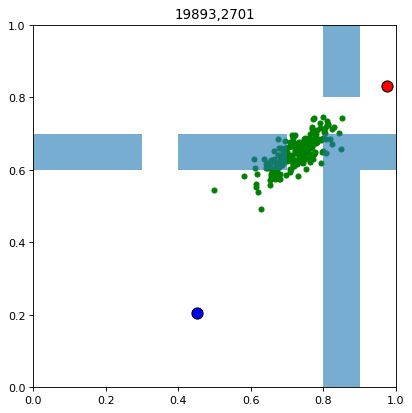

In [21]:
#net = CVAE()
#net.load_state_dict(torch.load(
#      "/home/zhizuo/lego/Model/lego2dCVAE_2019_12_27_16.pkl"))
num_viz = 200
# sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
#vizIdx = 88
print(vizIdx)
#c_sample_seed = data[numTrain + vizIdx, 2:]
c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    z = z.view(1, 2, 1,-1)
    tmp = c_sample_seed[0:4]
    tmp = tmp.view(1, 4, 1, -1)
    z = torch.cat((z, tmp), 1)
    z_deconv = net.deconv_de(z)
    c = c_sample_seed[4:104].view(1, 1, 10, 10)
    y = net.decoder(torch.cat((z_deconv, c),1))
    y = y.view(1, 128)
    predict = net.predict_mlp(y)
    y_viz[i,:] = predict
    
y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


# Train for DOF Landmark Dataset

In [ ]:
ratioTestTrain = 0.8
numEntries = landmark_data.shape[0]
numTrain = int(numEntries * ratioTestTrain)
X_train = landmark_data[0:numTrain,100:102]
c_train = landmark_data[0:numTrain,0:100]
X_test = landmark_data[numTrain:numEntries,100:102]
c_test = landmark_data[numTrain:numEntries,0:100]
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)

net = CVAE_MLP()
#resume = "/home/zhizuo/lego/Model/lego2dCVAE_2020_3_4_0.pkl"
#resume == None
#if resume == None:
#    net = CVAE_CNN()
#else:
#    net.load_state_dict(torch.load(resume))
if(torch.cuda.is_available()):
    net.cuda()
net.train()

optimizer = optim.Adam(net.parameters(), lr = opt.lr, betas=(opt.b1,opt.b2), 
                       eps = opt.eps, weight_decay = 0)

for epoch in range(opt.n_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0.0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} Recon = {:.8f}, KL = {:.8f}, Loss = {:.6f}".
         format(epoch + 1, i, recon_loss, kl_loss, loss))
    if(epoch + 1)%1000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(),
                  '/home/zhizuo/lego/Model/lego2d_CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE_CNN")
net.eval()

Starting the 1 epoch
Average loss of epoch 1 Recon = 682.00000000, KL = 0.38783458, Loss = 99.956390
Starting the 2 epoch
Average loss of epoch 2 Recon = 682.00000000, KL = 0.24451275, Loss = 97.403694
Starting the 3 epoch
Average loss of epoch 3 Recon = 682.00000000, KL = 0.21331200, Loss = 120.112122
Starting the 4 epoch
Average loss of epoch 4 Recon = 682.00000000, KL = 0.20904623, Loss = 122.604774
Starting the 5 epoch
Average loss of epoch 5 Recon = 682.00000000, KL = 0.18860741, Loss = 128.703003
Starting the 6 epoch
Average loss of epoch 6 Recon = 682.00000000, KL = 0.16114922, Loss = 120.740425
Starting the 7 epoch
Average loss of epoch 7 Recon = 682.00000000, KL = 0.15579909, Loss = 129.371063
Starting the 8 epoch
Average loss of epoch 8 Recon = 682.00000000, KL = 0.15855339, Loss = 127.962807
Starting the 9 epoch
Average loss of epoch 9 Recon = 682.00000000, KL = 0.13281532, Loss = 114.815910
Starting the 10 epoch
Average loss of epoch 10 Recon = 682.00000000, KL = 0.11393926

In [4]:
a = np.array([[4, 3],
              [3, 5]])
b = np.linalg.inv(a)
print(b)

[[ 0.45454545 -0.27272727]
 [-0.27272727  0.36363636]]
